# Decision Tree

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import math
import pydot
from IPython.display import Image, display
from collections import namedtuple

In [3]:
# If it complains about pydot.
# do this only once then comment it back
# try:
#     from pip import main as pipmain
# except:
#     from pip._internal import main as pipmain
# pipmain(['install', 'pydot'])


In [4]:
#if you are on a mac you may also need this
#http://brewformulas.org/Graphviz
# !brew install graphviz

Let us consider the data below.

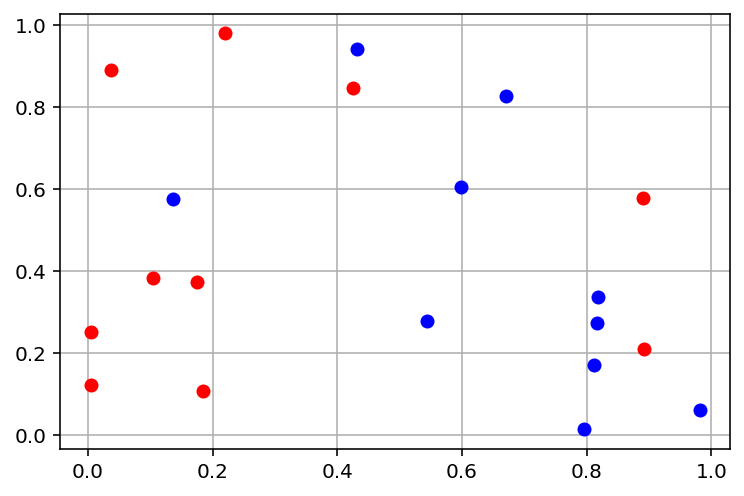

In [9]:
np.random.seed(100)
xs = np.random.random((20,2))
#print xs
cls = np.random.randint(0,2,20)*2-1
#print cls
plt.plot(xs[cls>0,0], xs[cls>0,1], 'ob')
plt.plot(xs[cls<0,0], xs[cls<0,1], 'or')
plt.grid(True)

1) Try to make a classifier with several if statements.

0.3333333333333333


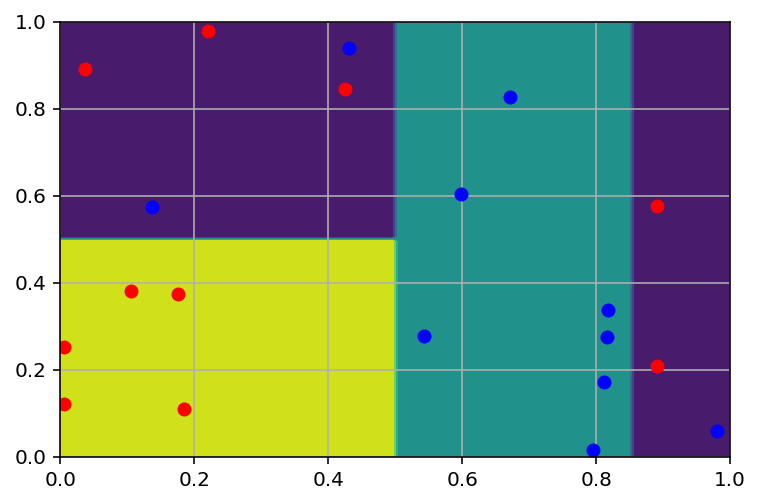

In [25]:
#return prob of being red
def bunch_of_ifs(data):
    x1, x2 = data
    if x1 < 0.5:
        if x2 < 0.5:
            return 1.0
        else:
            return 1./3.
    else:
        if x1 < 0.85:
            return 6/9
        else:
            return 1./3.
    

x1s = np.linspace(0,1,100)
x2s = np.linspace(0,1,100)
zs = np.zeros((100,100))
for ix1, x1 in enumerate(x1s):
    for ix2, x2 in enumerate(x2s):
        zs[ix1, ix2] = bunch_of_ifs([x1, x2])
plt.contourf(x1s, x2s, zs.T)
plt.plot(xs[cls>0,0], xs[cls>0,1], 'ob')
plt.plot(xs[cls<0,0], xs[cls<0,1], 'or')
plt.grid(True)
 
    
print(bunch_of_ifs([0.2, 0.8]))
    

2) We want to represent the code above with a tree. Try draw your code above with a tree.

In [27]:
#Here are some helpers
#node must have field left and right representing left and right node.
#the label on the node is from __str__ method
def visualize_tree(node, depth_limit=10):
    graph = pydot.Dot(graph_type='digraph')
    visualize_tree_helper(node, graph, 0, depth_limit=depth_limit)
    display(Image(graph.create_png()))
    return graph
    
def visualize_tree_helper(node, graph, depth, depth_limit=10):
    
    if depth > depth_limit:
        print('Traversing too deep')
        dotnode = pydot.Node('n%d'%id(node), label=str(node), shape="diamond", fillcolor="green", style="filled")
        graph.add_node(dotnode)
        return dotnode
      
    if not node.is_leaf():
        dotnode = pydot.Node('n%d'%id(node),label=str(node), shape="box")
    else:
        dotnode = pydot.Node('n%d'%id(node),label=str(node), shape="ellipse")
    graph.add_node(dotnode)
    
    if node.left is not None:
        dotleft = visualize_tree_helper(node.left, graph, depth+1, depth_limit)
        edge = pydot.Edge(dotnode, dotleft, label="Y")
        graph.add_edge(edge)
    if node.right is not None:
        dotright = visualize_tree_helper(node.right, graph, depth+1, depth_limit)
        edge = pydot.Edge(dotnode, dotright, label="N")
        graph.add_edge(edge)
    return dotnode

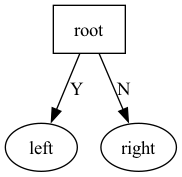

In [28]:
class Node:
    def __init__(self, msg='label'):
        self.left = None
        self.right = None
        self.msg = msg
        
    def is_leaf(self):
        return self.left is None and self.right is None
    
    def __str__(self):
        return self.msg

test_root = Node('root')
test_root.left = Node('left')
test_root.right = Node('right')
graph = visualize_tree(test_root)

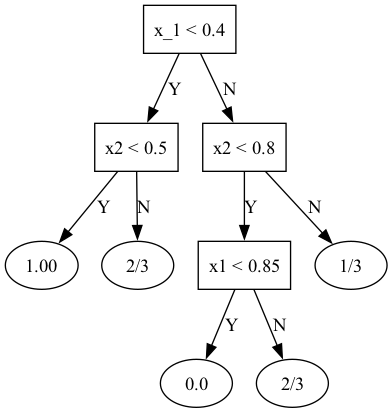

In [29]:
root = Node('x_1 < 0.4')
root.left = Node('x2 < 0.5')
root.left.left = Node('1.00')
root.left.right = Node('2/3')
root.right = Node('x2 < 0.8')
root.right.left = Node('x1 < 0.85')
root.right.right = Node('1/3')
root.right.left.left = Node('0.0')
root.right.left.right = Node('2/3')
visualize_tree(root)

3) But we want our tree to be able to classify and not just draw a nice picture.

This means that 

- our tree should have a method call classify(data)
- each (decision) node should be able to make decision(Think about what info you need to do that).
- leaf node should just holds the probability.

Implement this (Subclass Node). (Debug it with visualize tree)

Note that calling super constructor in python is a bit weird: you will need to do:

``Node.__init__(self)`` within constructor

0.0
1.0


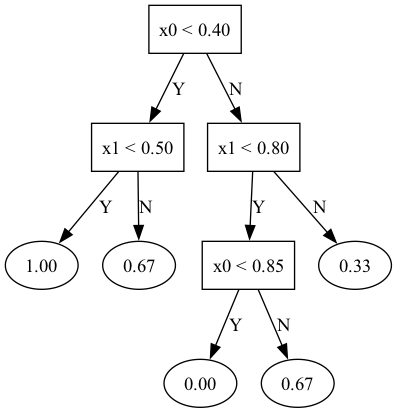

In [31]:
class DecisionNode(Node):
    def __init__(self, vid, cut, prob=-1.0):
        Node.__init__(self)
        self.vid = vid
        self.cut = cut
        self.prob = prob
    
    def classify(self, features):
        if self.is_leaf():
            return self.prob
        elif features[self.vid] < self.cut:
            return self.left.classify(features)
        else:
            return self.right.classify(features)
        
    def __str__(self):
        if not self.is_leaf():
            return 'x%d < %.2f'%(self.vid, self.cut)
        else:
            return '%.2f'%self.prob


root = DecisionNode(0, 0.4)
root.left = DecisionNode(1, 0.5)
root.left.left = DecisionNode(-1, -1, 1.0)
root.left.right = DecisionNode(-1, -1, 2./3.)
root.right = DecisionNode(1, 0.8)
root.right.left = DecisionNode(0, 0.85)
root.right.right = DecisionNode(-1, -1, 1./3.)
root.right.left.left = DecisionNode(-1, -1, 0.0)
root.right.left.right = DecisionNode(-1, -1, 2./3.)
print(root.classify([0.5, 0.5]))
print(root.classify([0.1, 0.1]))
visualize_tree(root)

4) Another way to visualize tree is by contour plot.

http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.contourf

Draw contour plot of the tree you had in 3)
<img src="contour.png"/>

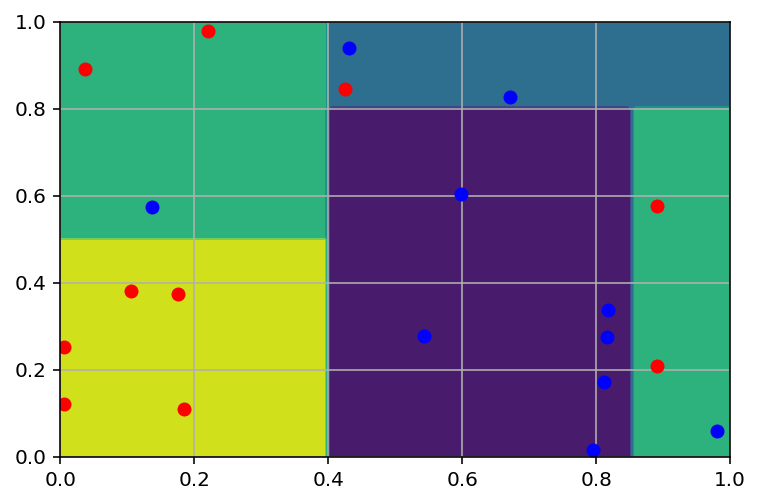

In [32]:

x1s = np.linspace(0,1,100)
x2s = np.linspace(0,1,100)
zs = np.zeros((100,100))
for ix1, x1 in enumerate(x1s):
    for ix2, x2 in enumerate(x2s):
        zs[ix1, ix2] = root.classify([x1, x2])
plt.contourf(x1s, x2s, zs.T)
plt.plot(xs[cls>0,0], xs[cls>0,1], 'ob')
plt.plot(xs[cls<0,0], xs[cls<0,1], 'or')
plt.grid(True)

Of course, we are not going to build this tree by hands. Our goal is to build a program which read the data and build a good tree. (Finding the best tree is probably NP problem.) So we are gonna go greedy here.


5) How do we pick the best split(which variable and where)? What does it mean intuitively?

6) Write a function: given features and class and pick the best split. (Think about how we should represent split?)

7) We want to grow a decision tree we need to stop somewhere. When should we stop?

In [58]:
def purity(cls_arr):
    n_data = len(cls_arr)
    n_one = sum(cls_arr > 0)
    p = float(n_one)/n_data
    return -(p-0.5)**2

def find_cut(data, cls):
    n_data, n_var = data.shape
    best_score = None
    best_vid, best_cut = None, None
    for vid in range(n_var):
        # find min and max
        min_value, max_value = min(data[:, vid]), max(data[:, vid])
        for cut in np.linspace(min_value, max_value, 12)[1:-1]: #  ignore the boundary
            left_mask = data[:, vid] < cut
            right_mask = ~left_mask
            
            if sum(left_mask) == 0 or sum(right_mask) == 0:
                continue
            
            left_purity = purity(cls[left_mask])
            right_purity = purity(cls[right_mask])
            
            score = left_purity + right_purity
            # print(vid, cut, score, left_purity, right_purity)
            if best_score is None or score < best_score:
                best_score = score
                best_vid = vid
                best_cut = cut
    return best_vid, best_cut

def build_node(data, cls, min_leaf_size) -> DecisionNode:
    if len(data) <= min_leaf_size:
        p = sum(cls>0)/len(cls)
        return DecisionNode(None, None, prob=p)
    else:
        vid, cut = find_cut(data, cls)
        this_node = DecisionNode(vid, cut)
        left_mask = data[: , vid] < cut
        right_mask = ~left_mask
        # build left
        this_node.left = build_node(data[left_mask], cls[left_mask], min_leaf_size)
        # build right
        this_node.right = build_node(data[right_mask], cls[right_mask], min_leaf_size)
        return this_node

                
find_cut(features, cls)        
        # compute score for all the cuts
    # find the best one

(0, 3.2713900552668473)

In [64]:
root = build_node(features, cls, 100)

Traversing too deep
Traversing too deep
Traversing too deep
Traversing too deep


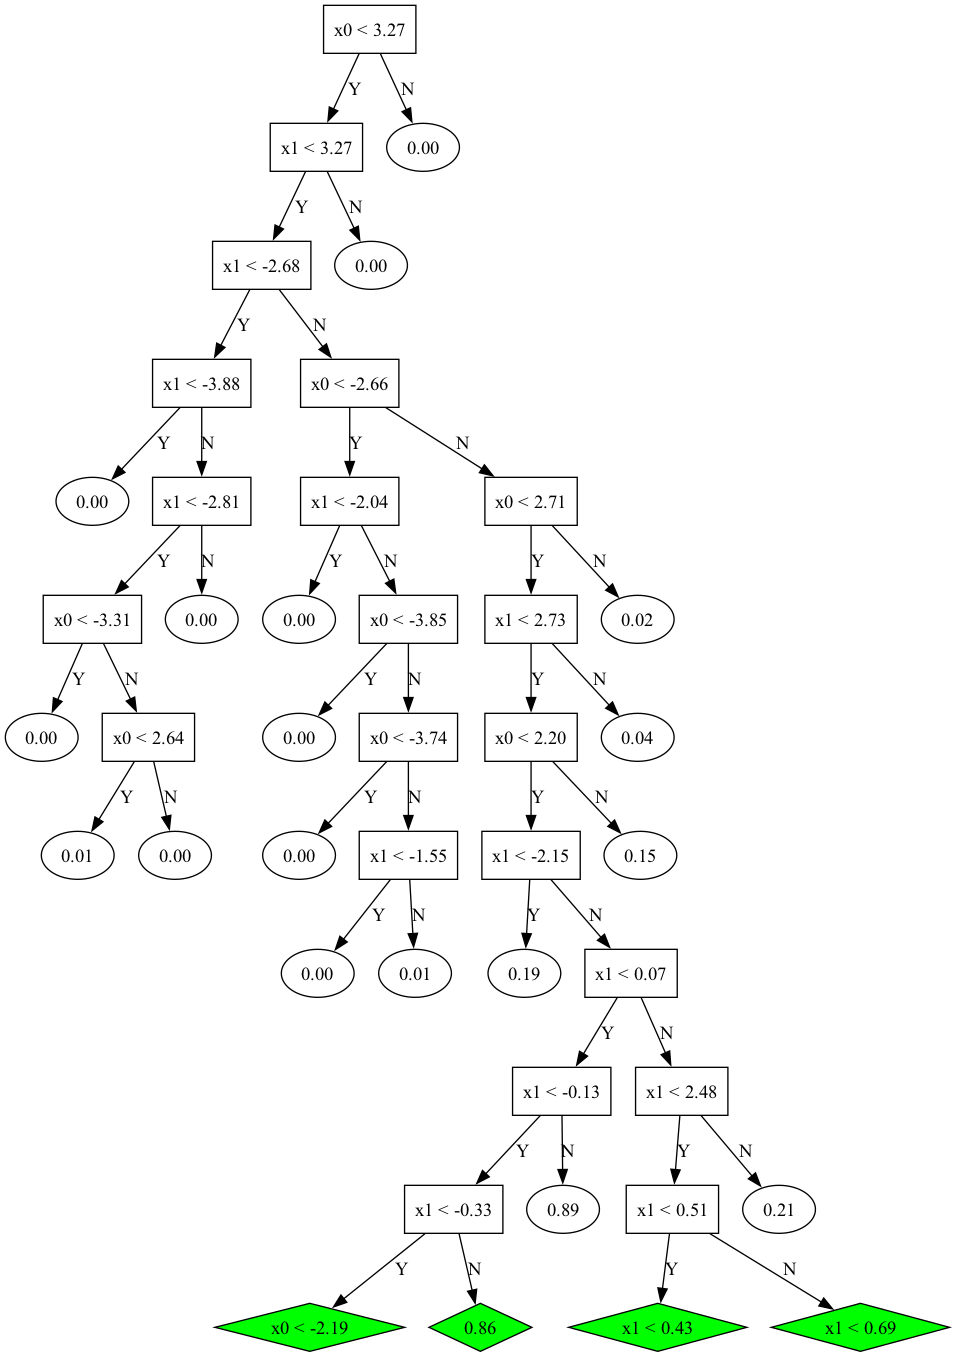

In [65]:
visualize_tree(root)

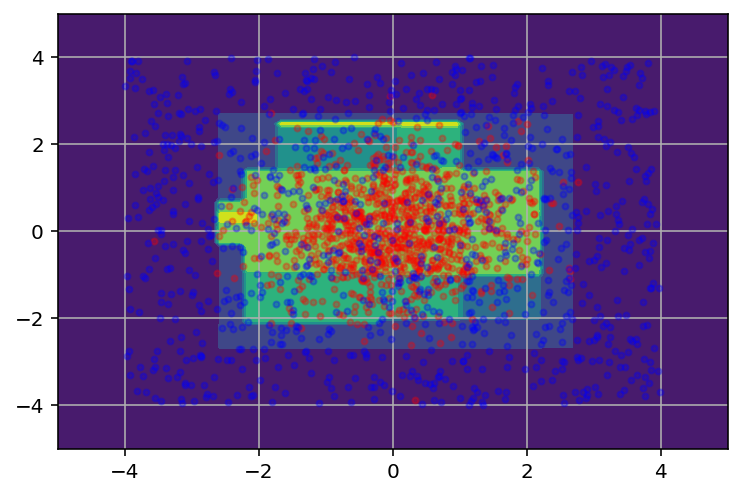

In [66]:
np.random.seed(1234)
xp1 = np.random.randn(1000,1)
xp2 = np.random.randn(1000,1)
pcls = np.zeros((1000))
pcls[:] = 1
xn1 = np.random.random((1000,1))*8-4
xn2 = np.random.random((1000,1))*8-4
ncls = np.zeros((1000))
ncls[:] = -1
x1s = np.concatenate([xp1, xn1])
x2s = np.concatenate([xp2, xn2])
cls = np.concatenate([pcls, ncls])
features = np.concatenate((x1s, x2s), axis=1)

cls>0
plt.plot(features[cls>0, 0], features[cls>0, 1], '.r', alpha=0.3)
plt.plot(features[cls<0, 0], features[cls<0, 1], '.b', alpha=0.3)

x1s = np.linspace(-5,5,100)
x2s = np.linspace(-5,5,100)
zs = np.zeros((100,100))
for ix1, x1 in enumerate(x1s):
    for ix2, x2 in enumerate(x2s):
        zs[ix1, ix2] = root.classify([x1, x2])
plt.contourf(x1s, x2s, zs.T)
plt.grid(True)



8) Now consider this data. Write a function that grow decision tree. Of course, you will need to 

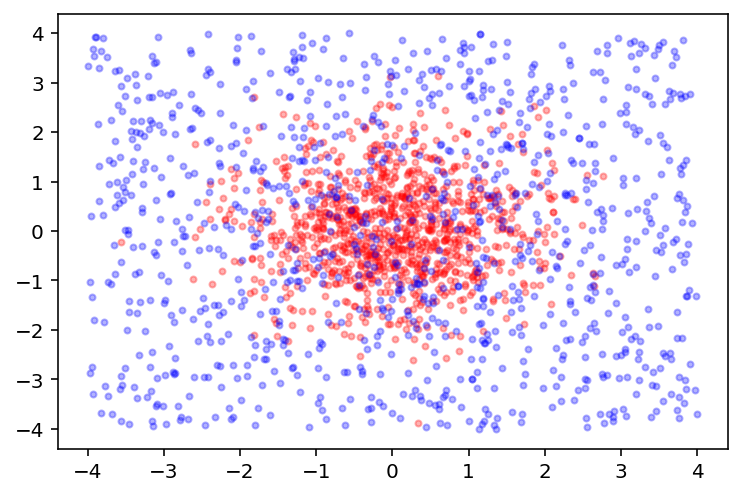

In [33]:
np.random.seed(1234)
xp1 = np.random.randn(1000,1)
xp2 = np.random.randn(1000,1)
pcls = np.zeros((1000))
pcls[:] = 1
xn1 = np.random.random((1000,1))*8-4
xn2 = np.random.random((1000,1))*8-4
ncls = np.zeros((1000))
ncls[:] = -1
x1s = np.concatenate([xp1, xn1])
x2s = np.concatenate([xp2, xn2])
cls = np.concatenate([pcls, ncls])
features = np.concatenate((x1s, x2s), axis=1)

cls>0
plt.plot(features[cls>0, 0], features[cls>0, 1], '.r', alpha=0.3)
plt.plot(features[cls<0, 0], features[cls<0, 1], '.b', alpha=0.3)

9) Visualize what you build with contour plot. What do you see? Why do you think that happen?

<img src="contour2.png"/>

10) What is the advantage of this method over stuff like linear regression?

11) What happen if minleaf is too small?

# k-Nearest Neighborhood

In [23]:
#implement and make contour plot

# Quick Non Linear Logistic

1) Try logistic regression with (How do I know that we need this transformation?)
$$(x_1, x_2) \to (1, x_1,x_1^2,x_2, x_2^2, x_1x_2)$$

# ROC

1) Easiest way to visualize them is ROC. Plot it (write your own first). Then use the library for the rest of your life.